# Description

The notebook monitors a shadow trading run, i.e. displays performance metrics (e.g., pnl).

Note: this is a copy of `oms/notebooks/Master_PnL_real_time_observer.old.py` adapted for shadow trading runs.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import helpers.hs3 as hs3
import reconciliation as reconcil

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-22d57f2d-f37a-46b2-b998-bbe72e10f3f5.json'
INFO  # Git
  branch_name='CmTask8168_Move-Master_shadow_trading_system_observer_notebook_to_master'
  hash='07776a2a7'
  # Last commits:
    *   07776a2a7 Vedanshu7 Merge branch 'CmTask8168_Move-Master_shadow_trading_system_observer_notebook_to_master' of github.com:cryptokaizen/cmamp into CmTask8168_Move-Master_shadow_trading_system_observer_notebook_to_master (26 minutes ago) Wed May 15 15:31:00 2024  (HEAD -> CmTask8168_Move-Master_shadow_trading_system_observer_notebook_to_master, origin/CmTask8168_Move-Master_shadow_trading_system_observer_notebook_to_master)
    |\  
    * | 5f5b60783 Vedanshu7 Linter                                                            (26 minutes ago) Wed May 15 15:30:48 2024           
    | * 6b7c8c8bc Vedanshu Joshi Merge branch 'master' into CmTask8168_Move-Master_shadow_trading_system_observer_n

# Last update time

In [4]:
# TODO(Grisha): tz should go to notebook's config.
tz = "ET"
current_time = hdateti.get_current_time(tz)
print(current_time)

2024-05-15 11:56:38.742777-04:00


# Build the reconciliation config

In [5]:
# When running manually, specify the path to the config to load config from file,
# for e.g., `.../reconciliation_notebook/fast/result_0/config.pkl`.
config_file_name = None
# Set 'replace_ecs_tokyo = True' if running the notebook manually.
replace_ecs_tokyo = False
config = cconfig.get_notebook_config(
    config_file_path=config_file_name, replace_ecs_tokyo=replace_ecs_tokyo
)
if config is None:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    prod_data_root_dir = "/shared_data2/ecs_tokyo/preprod/system_reconciliation"
    dag_builder_ctor_as_str = (
        "dataflow_lemonade.pipelines.C11.C11a_pipeline.C11a_DagBuilder"
    )
    run_mode = "paper_trading"
    start_timestamp_as_str = "20240509_134000"
    end_timestamp_as_str = "20240510_130500"
    mode = "manual"
    save_plots_for_investors = True
    tag = "config1"
    html_bucket_path = henv.execute_repo_config_code("get_html_bucket_path()")
    s3_dst_dir = os.path.join(html_bucket_path, "pnl_for_investors")
    config_list = reconcil.build_system_observer_configs(
        prod_data_root_dir,
        dag_builder_ctor_as_str,
        run_mode,
        start_timestamp_as_str,
        end_timestamp_as_str,
        mode,
        save_plots_for_investors,
        tag=tag,
        s3_dst_dir=s3_dst_dir,
    )
    config = config_list[0]
print(config)

WARNING No config found, returning None
INFO  Using hardwired config
INFO  run_date='20240509'
INFO  Using run_date=20240509
INFO  dst_root_dir='/shared_data2/ecs_tokyo/preprod/system_reconciliation', dag_builder_name='C11a', run_mode='paper_trading', start_timestamp_as_str='20240509_134000', end_timestamp_as_str='20240510_130500'
INFO  target_dir='/shared_data2/ecs_tokyo/preprod/system_reconciliation/C11a.config1/paper_trading/20240509_134000.20240510_130500'
INFO  system_log_dir='system_log_dir.manual'
meta: 
  dag_builder_name: C11a
  date_str: 20240509
  bar_duration: 5T
  save_plots_for_investors: True
  tag: config1
s3_dst_dir: s3://cryptokaizen-html/pnl_for_investors
system_log_dir: /shared_data2/ecs_tokyo/preprod/system_reconciliation/C11a.config1/paper_trading/20240509_134000.20240510_130500/system_log_dir.manual
dag_builder_ctor_as_str: dataflow_lemonade.pipelines.C11.C11a_pipeline.C11a_DagBuilder
research_forecast_evaluator_from_prices: 
  init: 
    price_col: open
    pred

# System config

In [6]:
# # Load the system config.
config_file_name = "system_config.output.values_as_strings.pkl"
system_config_path = os.path.join(config["system_log_dir"], config_file_name)
system_config = cconfig.load_config_from_pickle(system_config_path)
print(system_config)

dag_config: 
  generate_feature_panels: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
    out_col_group: ()
    transformer_kwargs: 
      bar_normalization_method: volume
  resample: 
    in_col_groups: [('open',), ('high',), ('low',), ('close',), ('volume',), ('p1',), ('p2',), ('p3',), ('p_lr',), ('p_est',), ('p_diff',), ('q1',), ('q2',), ('q3',), ('q4',), ('q5',), ('q6',), ('q_mv',), ('q_mv_adj',), ('q_mv_os',), ('r1',), ('r2',), ('r3',), ('r4',), ('r5',), ('r6',), ('r_lr',), ('r_est',), ('v_ld',)]
    out_col_group: ()
    transformer_kwargs: 
      rule: 5T
      volume_weight: volume
    reindex_like_input: False
    join_output_with_input: False
  compute_vol: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',)]
    out_col_group: ()
    transformer_kwargs: 
      estimators: ['close', 'parkinson', 'garman_klass']
      open_col: open
      high_col: high
      low_col: low
      close_col: close
      apply_log: True
      take_square

# Specify data to load

In [7]:
# Points to `system_log_dir/process_forecasts/portfolio`.
data_type = "portfolio"
portfolio_path = reconcil.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("portfolio_path=%s", portfolio_path)

INFO  portfolio_path=/shared_data2/ecs_tokyo/preprod/system_reconciliation/C11a.config1/paper_trading/20240509_134000.20240510_130500/system_log_dir.manual/process_forecasts/portfolio


# Portfolio

## Load logged portfolios (prod)

In [8]:
_, portfolio_stats_dfs = reconcil.load_portfolio_dfs(
    {"prod": portfolio_path},
    config["meta"]["bar_duration"],
)

portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
#
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=prod path=/shared_data2/ecs_tokyo/preprod/system_reconciliation/C11a.config1/paper_trading/20240509_134000.20240510_130500/system_log_dir.manual/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/282 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/282 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/282 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/282 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/282 [00:00<?, ?it/s]

prod                                                                                        
                                pnl gross_volume  net_volume           gmv          nmv         cash  net_wealth   leverage
2024-05-09 09:50:00-04:00       NaN          0.0         0.0           0.0          0.0        700.0       700.0        0.0
2024-05-09 09:55:00-04:00  15.11471  15614.81108  5659.96092   15604.10835   5675.07563  -4959.96092   715.11471  21.820427
                                ...          ...         ...           ...          ...          ...         ...        ...
2024-05-10 09:10:00-04:00 -31.73658  82588.58153 -5129.39933  104863.23467  18934.71033 -17795.23152  1139.47881  92.027367
2024-05-10 09:15:00-04:00   3.09246  62404.08132 -5376.12784  104926.31341  13561.67495 -12419.10368  1142.57127  91.833495

## Compute Portfolio statistics (prod vs research)

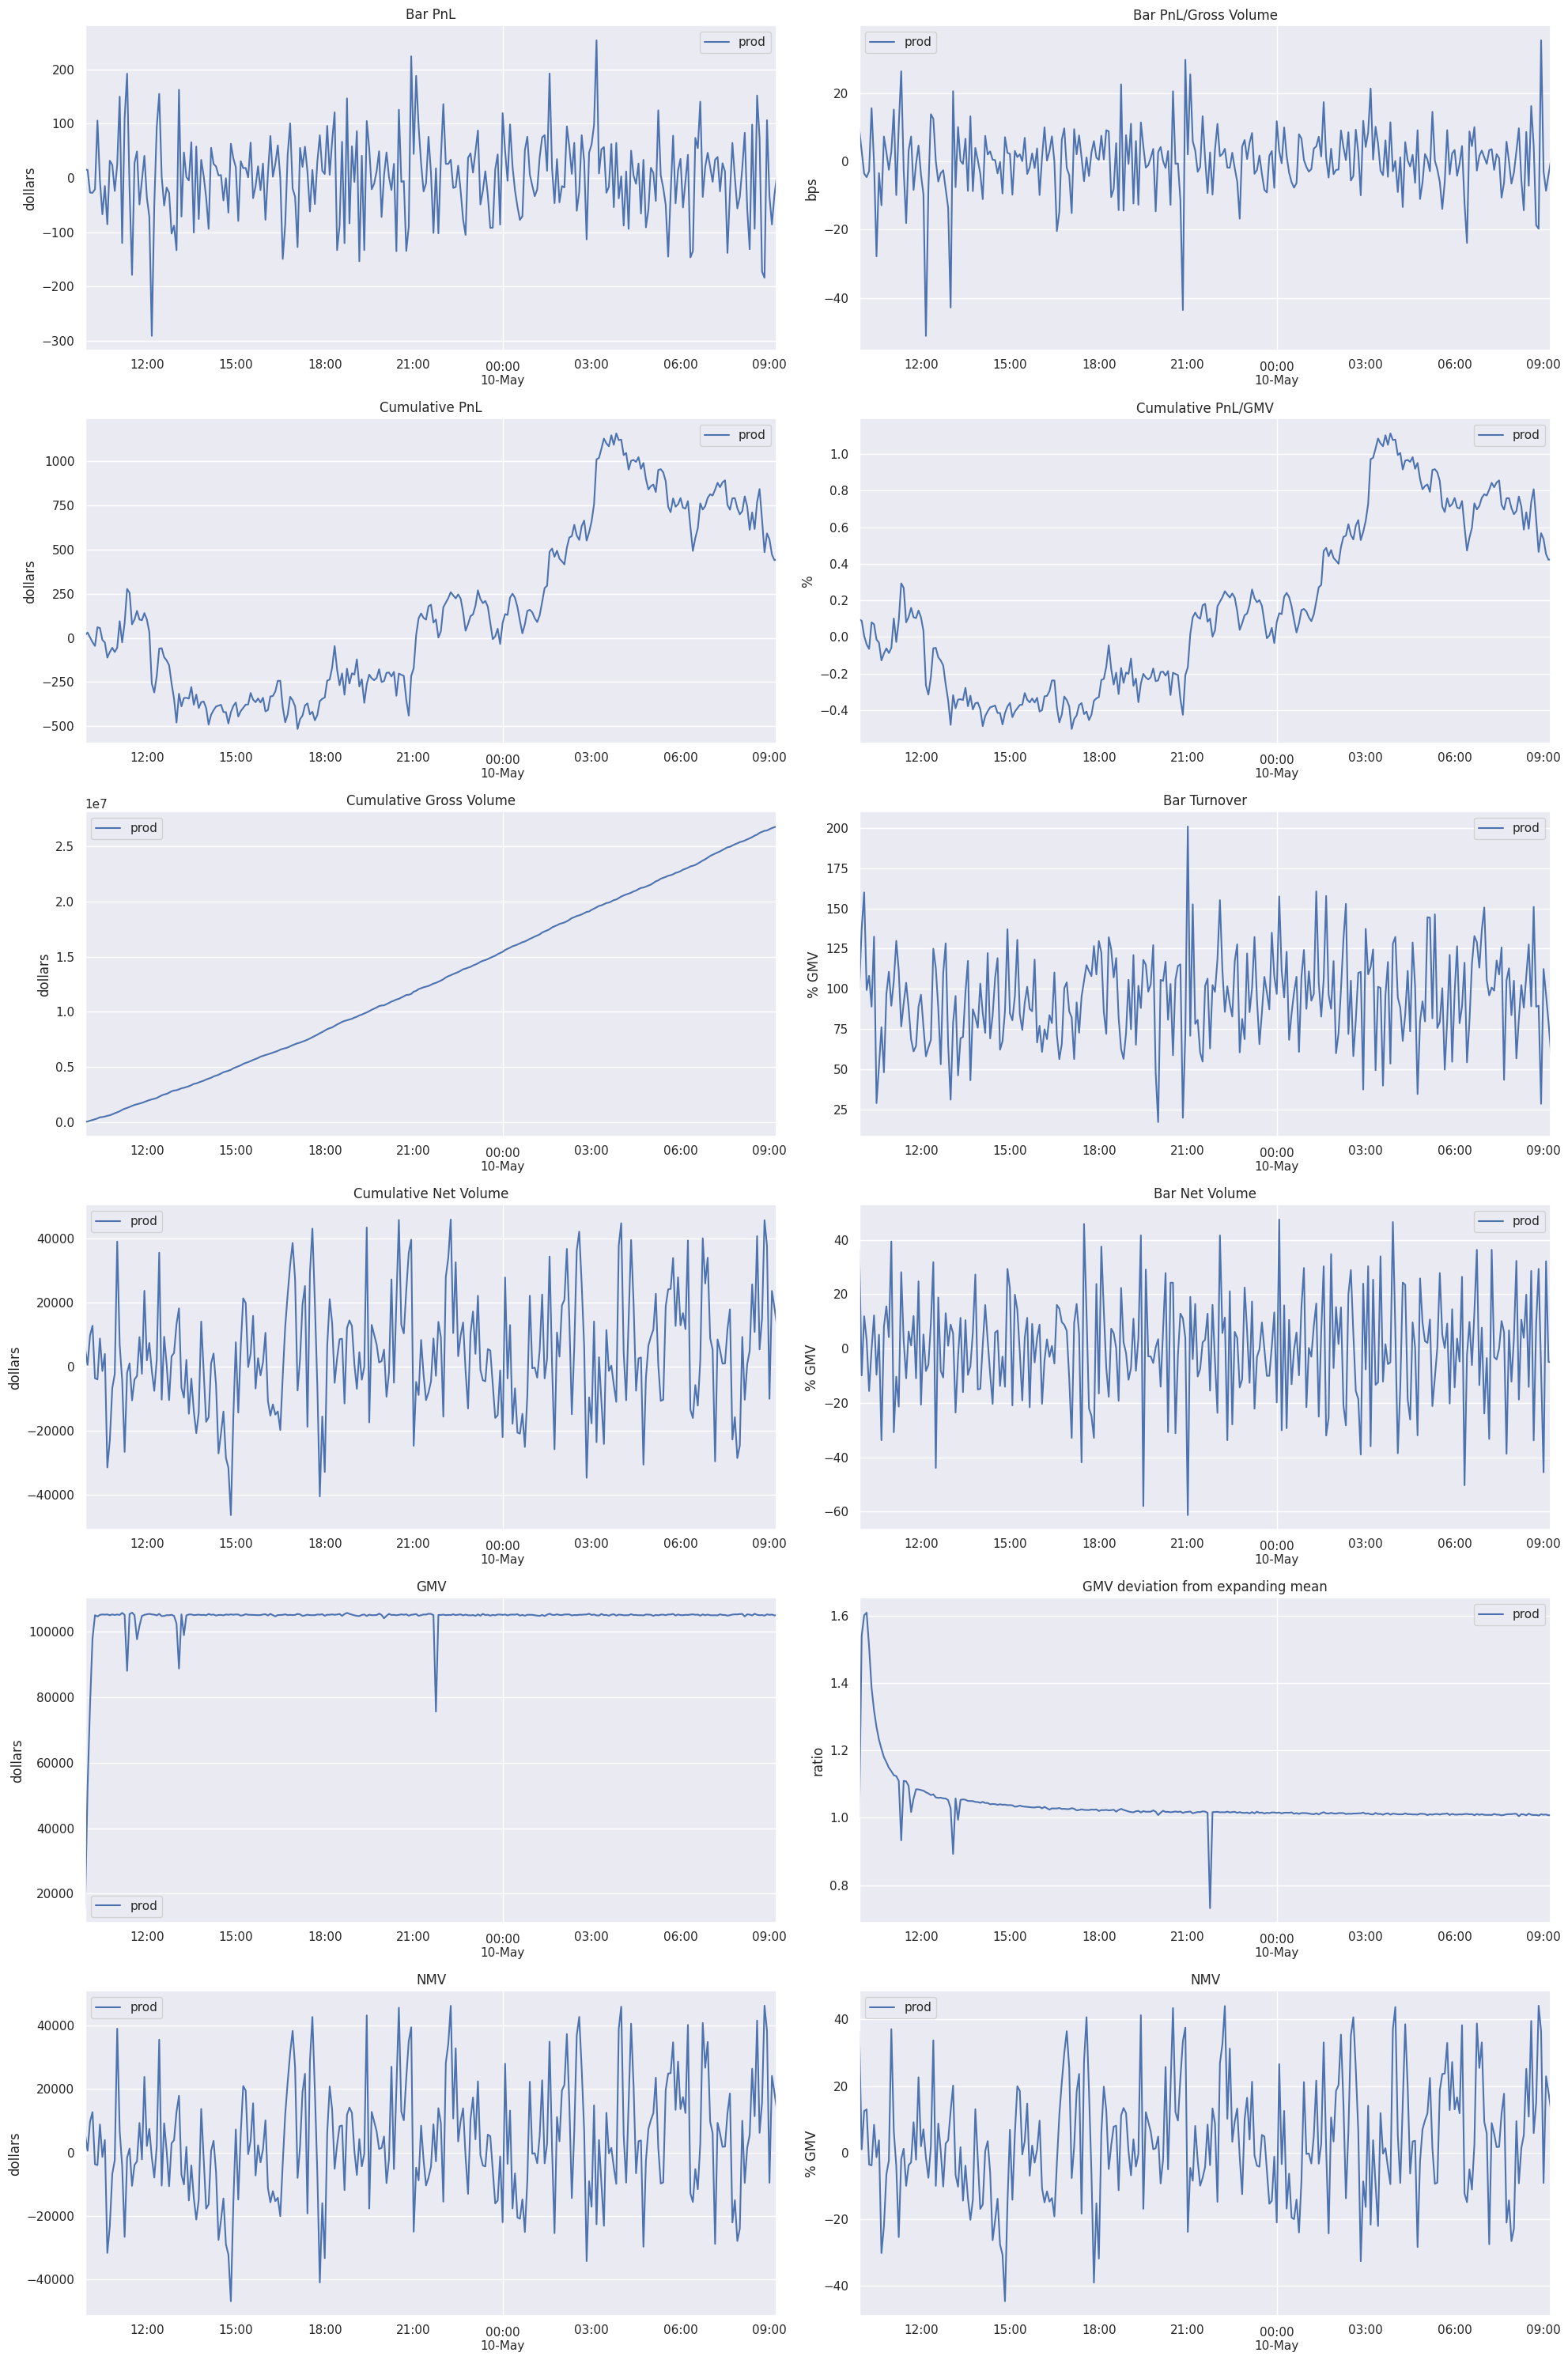

In [9]:
bars_to_burn = 1
coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])

In [10]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], config["meta"]["bar_duration"]
)
display(stats_sxs)

prod
ratios     sharpe_ratio                      6.82
           sharpe_ratio_standard_error      19.38
           sr.tval                           0.35
           sr.pval                           0.72
           kratio                           26.55
dollar     gmv_mean                     104097.07
           gmv_stdev                      6788.27
           annualized_mean_return       165619.50
           annualized_volatility         24281.87
           max_drawdown                    791.29
           pnl_mean                          1.57
           pnl_std                          74.88
           turnover_mean                 95304.08
           turnover_stdev                29383.89
           market_bias_mean               3767.37
           market_bias_stdev             18095.50
percentage annualized_mean_return          159.10
           annualized_volatility            23.33
           max_drawdown                      0.76
           pnl_mean                          0.00
           pnl_std                           0.07
           turnover_mean                    91.55
           turnover_stdev                   28.23
           market_bias_mean                  3.62
           market_bias_stdev                17.38

# PnL for investors

In [11]:
# TODO(Grisha): move to a lib.
def adjust_matplotlib_settings() -> None:
    """
    Adjust the Matplotlib settings for readability.
    """
    # Matplotlib setting to make the plots readable in presentations.
    matplotlib.rcParams.update({"font.size": 22})
    #
    BIG_SIZE = 22
    #
    plt.rc("font", size=BIG_SIZE)  # controls default text sizes
    plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
    plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
    plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title
    #
    matplotlib.rcParams["figure.dpi"] = 300


# TODO(Grisha): move to a lib.
def plot_cumulative_pnl(
    cumul_pnl: pd.Series,
    plot_title: str,
    *,
    save_to_tmp_file: bool = True,
    copy_to_s3: bool = True,
    s3_dst_file_path: Optional[str] = None,
) -> None:
    """
    Plot cumulative PnL.

    :param cumul_pnl: cumulative PnL
    :param plot_title: title for the plot
    :param save_to_tmp_file: save the plot locally to a tmp file if True,
        proceed otherwise
    :param copy_to_s3: copy to the saved plot to S3 if True, proceed otherwise
    :param s3_dst_file_path: path on S3 to copy the saved plot to, e.g.,
        `s3://.../system_reconciliation/test_image.png`
    """
    adjust_matplotlib_settings()
    ax = cumul_pnl.plot(title=plot_title)
    # Set the labels formatting, e.g., `1000.0` -> `$1,000`.
    ax.yaxis.set_major_formatter("${x:,.0f}")
    if save_to_tmp_file:
        # Save the plot locally to a tmp file.
        tmp_file_path = "/app/tmp.png"
        _LOG.info("Saving the PnL plot to %s", tmp_file_path)
        plt.savefig(tmp_file_path, bbox_inches="tight")
        if copy_to_s3:
            # Copy a tmp file to S3.
            aws_profile = "ck"
            hs3.copy_file_to_s3(tmp_file_path, s3_dst_file_path, aws_profile)
    # Saving must precede `show()`.
    plt.show()

INFO  Saving the PnL plot to /app/tmp.png
INFO  Copying from /app/tmp.png to s3://cryptokaizen-html/pnl_for_investors/cumulative_pnl.last_24hours.png
upload: ../../../tmp.png to s3://cryptokaizen-html/pnl_for_investors/cumulative_pnl.last_24hours.png


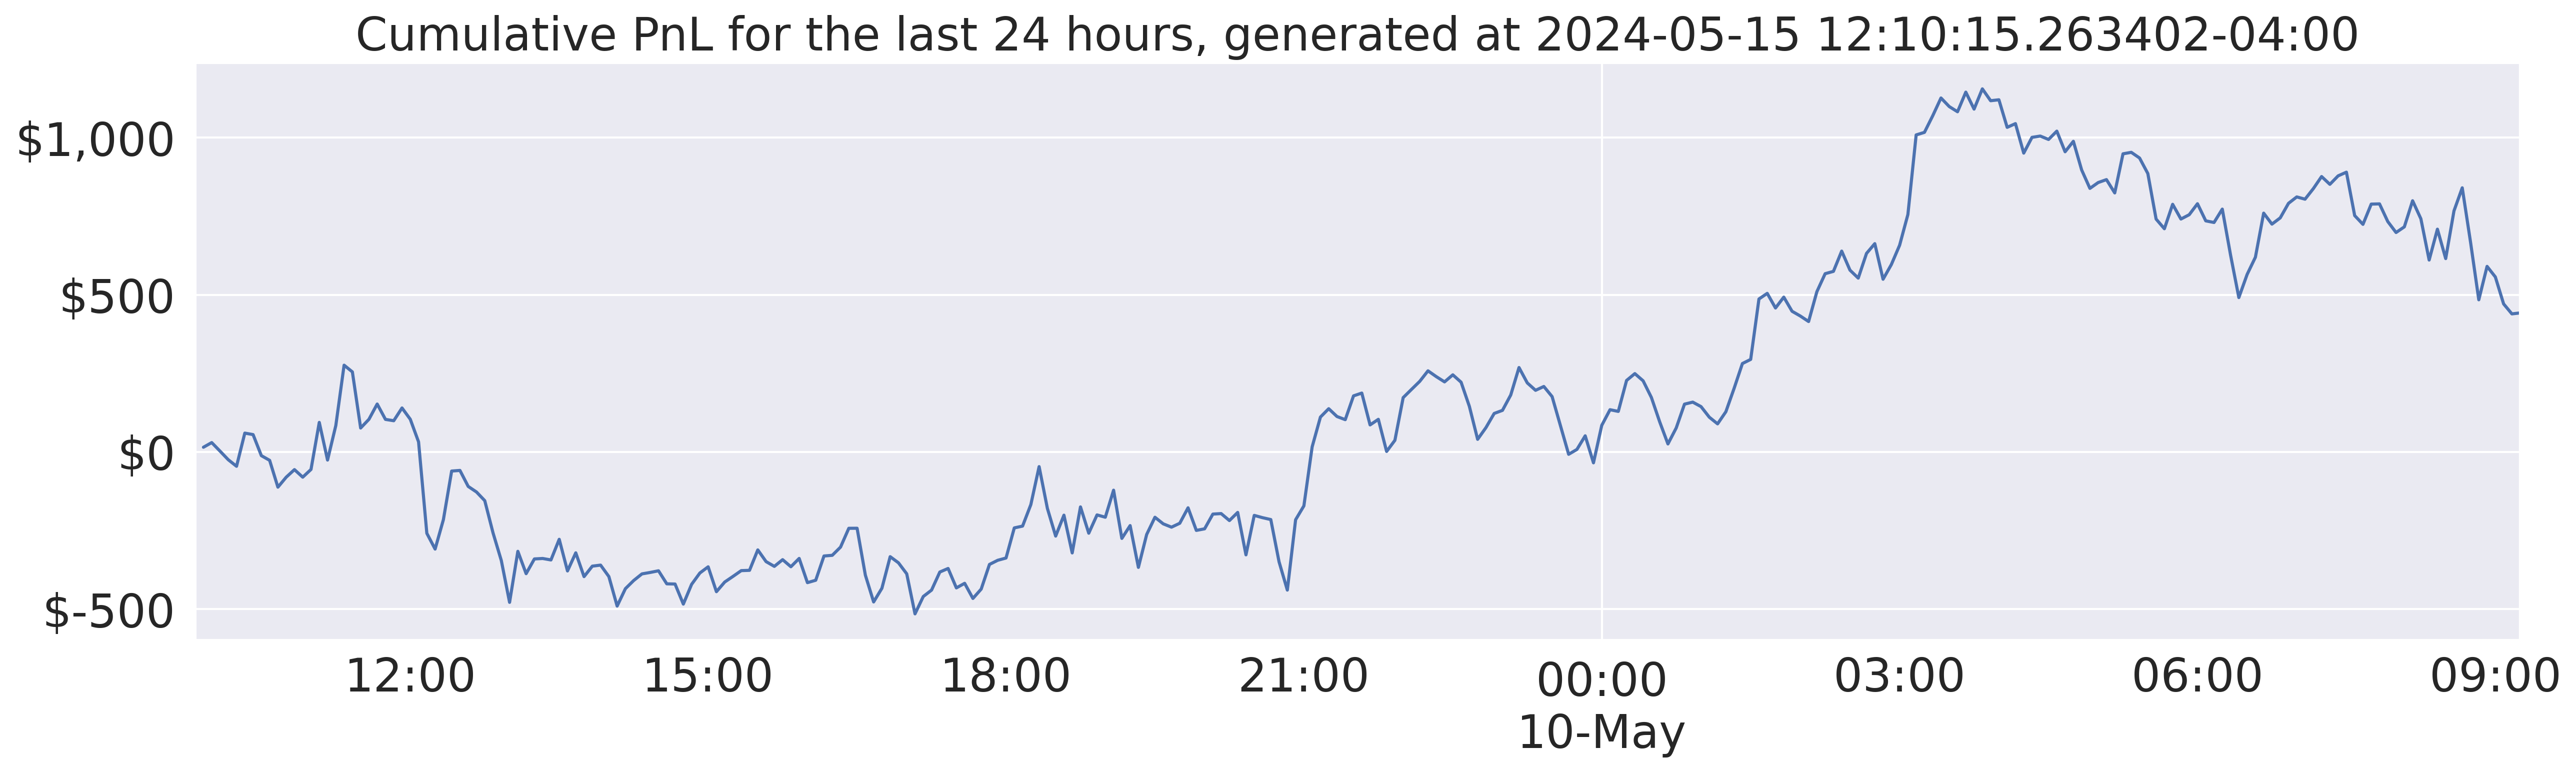

In [12]:
if (
    config["meta"]["dag_builder_name"] == "C11a"
    and config["meta"]["save_plots_for_investors"]
    and config["meta"]["tag"] == "config1"
):
    pnl_df = portfolio_stats_df["prod"]
    # Get the number of hours for which the system is run.
    bar_duration_in_minutes = int(config["meta"]["bar_duration"].rstrip("T"))
    pnl_num_hours = pnl_df.shape[0] * bar_duration_in_minutes / 60
    # Verify that the number of hours is in [0,24] range.
    hdbg.dassert_lgt(
        0,
        pnl_num_hours,
        24,
        lower_bound_closed=False,
        upper_bound_closed=True,
    )
    # TODO(Grisha): this is a hack. Ideally we should schedule a DAG
    # after the prod run is finished to get a plot for 24 hours.
    current_et_time = hdateti.get_current_time("ET")
    if round(pnl_num_hours) == 24:
        # A 24 hours run is a complete run so save as the last 24 hours results.
        file_name = "cumulative_pnl.last_24hours.png"
        plot_title = f"Cumulative PnL for the last 24 hours, generated at {current_et_time}"
    else:
        # If a run is not complete save as last 5 minutes results.
        file_name = "cumulative_pnl.last_5minutes.png"
        plot_title = (
            f"Cumulative PnL for current run, generated at {current_et_time}"
        )
    cumul_pnl = pnl_df["pnl"].cumsum()
    s3_dst_path = os.path.join(config["s3_dst_dir"], file_name)
    save_to_tmp_file = True
    copy_to_s3 = True
    plot_cumulative_pnl(
        cumul_pnl,
        plot_title,
        save_to_tmp_file=save_to_tmp_file,
        copy_to_s3=copy_to_s3,
        s3_dst_file_path=s3_dst_path,
    )